Deep learning project aa 2023/24

Libraries

In [1]:
import os
import threading
import time
import sys

import torch as th
import torch.nn as nn
import numpy as np
import pandas as pd
import tensorflow as tf
# For the progress bar
from tqdm import tqdm

Function that perform the onehot encoding

In [2]:
def onehot_encoder(dataset):
    """
    Function that encodes a DNA dataset into a onehot encoding dataset.
    """
    onehot_dataset = [dna_onehot_encoder(dna_string) for dna_string in dataset]
    onehot_dataset_numpy = np.array(onehot_dataset)

    return onehot_dataset_numpy


def dna_onehot_encoder(dna_sequence):
    """
    Function that encodes a single DNA string into a onehot encoding string.
    """
    onehot_dict = {
        'A' : [1, 0, 0, 0],
        'C' : [0, 1, 0, 0],
        'G' : [0, 0, 1, 0],
        'T' : [0, 0, 0, 1]
    }
    encoder = [onehot_dict[nuc] for nuc in dna_sequence]

    return encoder


Data encoding

In [3]:
#! - TESTER
path = './data/fullset_test.csv'

# Read the input from the csv file
csv = pd.read_csv(path, sep=",")
# Drop the NaN values
csv = csv.dropna()
# Describe the data
csv.describe()

# Get the data from the csv file
data = csv.values
# m = number of input samples
m = data.shape[0]
print("Amount of data:",m)
X = data[:m,1]
Y = data[:m,2].astype(np.int32)

# # Reduce the size of the dataset for testing
m = 5
X = X[:m]
Y = Y[:m]

# OneHot encoding for the training data
print("Start onehot encoding for the training data")
X = onehot_encoder(X)

# Convert the data to a tensor
X = th.tensor(X)
Y = th.tensor(Y)

print("X_train shape: ", X.shape)
print("Y_train shape: ", Y.shape)

# Free memory
del csv, data, m

Amount of data: 26404
Start onehot encoding for the training data
X_train shape:  torch.Size([5, 300, 4])
Y_train shape:  torch.Size([5])


In [4]:
#!- MAIN

# Set the device to be used (GPU or CPU)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Device: ", device)

# Read the input from the cvc file
rel_path_train = './data/fullset_train.csv'
rel_path_val = './data/fullset_validation.csv'
rel_path_test = './data/fullset_test.csv'

# Training Set

# Read the input from the csv file
train_csv = pd.read_csv(rel_path_train, sep=",")
# Drop the NaN values
train_csv = train_csv.dropna()
# Describe the data
train_csv.describe()

# Get the data from the csv file
train_data = train_csv.values
# m = number of input samples
m = train_data.shape[0]
print("Amount of data:",m)
X_train = train_data[:m,1]
Y_train = train_data[:m,2].astype(np.int32)

# # Reduce the size of the dataset for testing
# m = 100000
# X_train = X_train[:m]
# Y_train = Y_train[:m]

# OneHot encoding for the training data
print("Start onehot encoding for the training data")
X_train = onehot_encoder(X_train)

# Convert the data to a tensor
X_train = th.from_numpy(X_train)
Y_train = th.tensor(Y_train)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)

# Free memory
del train_csv, train_data, m

# Validation Set

# Read the input from the csv file
val_csv = pd.read_csv(rel_path_val, sep=",")
# Drop the NaN values
val_csv = val_csv.dropna()
# Describe the data
val_csv.describe()

val_data = val_csv.values
# m = number of input samples
m = val_data.shape[0]
print("Amount of data:",m)
X_val = val_data[:m,1]
Y_val = val_data[:m,2].astype(np.int32)

# OneHot encoding for the validation data
print("Start onehot encoding for the validation data")
X_val = onehot_encoder(X_val)

X_val = th.from_numpy(X_val)
Y_val = th.tensor(Y_val)

print("X_val shape", X_val.shape)
print("Y_val shape", Y_val.shape)

# Free memory
del val_csv, val_data, m

# Test

# Read the input from the csv file
test_csv = pd.read_csv(rel_path_test, sep=",")
# Drop the NaN values
test_csv = test_csv.dropna()
# Describe the data
test_csv.describe()

test_data = test_csv.values
# m = number of input samples
m = test_data.shape[0]
print("Amount of data:",m)
X_test = test_data[:m,1]
Y_test = test_data[:m,2].astype(np.int32)

# OneHot encoding for the test data
print("Start onehot encoding for the test data")
X_test = onehot_encoder(X_test)

X_test = th.from_numpy(X_test)
Y_test = th.tensor(Y_test)

print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)

# Free memory
del test_csv, test_data, m

Device:  cpu
Amount of data: 211238
Start onehot encoding for the training data
X_train shape:  torch.Size([211238, 300, 4])
Y_train shape:  torch.Size([211238])
Amount of data: 26404
Start onehot encoding for the validation data
X_val shape torch.Size([26404, 300, 4])
Y_val shape torch.Size([26404])
Amount of data: 26404
Start onehot encoding for the test data
X_test shape torch.Size([26404, 300, 4])
Y_test shape torch.Size([26404])


Define the net

In [5]:
class GRU(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.conv1 = nn.Conv1d(300, 16, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool1d(2)  
        self.gru = nn.GRU(16, 64, num_layers=2, bidirectional=True) 
        self.fc1 = nn.Linear(256, 128) 
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.pool1(x)
        print(x.shape)
        x = x.permute(0, 2, 1) 
        print(x.shape)
        x, _ = self.gru(x)
        print(x.shape)
        x = x.flatten(1)
        print(x.shape)
        x = self.fc1(x)
        print(x.shape)
        x = self.fc2(x)
        print(x.shape)
        return x
    
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.conv1 = nn.Conv1d(300, 16, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool1d(2)  
        self.lstm = nn.LSTM(16, 64, num_layers=2, bidirectional=True) 
        self.fc1 = nn.Linear(256, 128) 
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.pool1(x)
        print(x.shape)
        x = x.permute(0, 2, 1) 
        print(x.shape)
        x, _ = self.lstm(x)
        print(x.shape)
        x = x.flatten(1)
        print(x.shape)
        x = self.fc1(x)
        print(x.shape)
        x = self.fc2(x)
        print(x.shape)
        return x

Train the model

torch.Size([211238, 16, 4])
torch.Size([211238, 16, 2])
torch.Size([211238, 2, 16])
torch.Size([211238, 2, 128])
torch.Size([211238, 256])
torch.Size([211238, 128])
torch.Size([211238, 2])
torch.Size([26404, 16, 4])
torch.Size([26404, 16, 2])
torch.Size([26404, 2, 16])
torch.Size([26404, 2, 128])
torch.Size([26404, 256])
torch.Size([26404, 128])
torch.Size([26404, 2])
Epoch [1/10], Train Loss: 0.7279, Val Loss: 0.5455
torch.Size([211238, 16, 4])
torch.Size([211238, 16, 2])
torch.Size([211238, 2, 16])
torch.Size([211238, 2, 128])
torch.Size([211238, 256])
torch.Size([211238, 128])
torch.Size([211238, 2])
torch.Size([26404, 16, 4])
torch.Size([26404, 16, 2])
torch.Size([26404, 2, 16])
torch.Size([26404, 2, 128])
torch.Size([26404, 256])
torch.Size([26404, 128])
torch.Size([26404, 2])
Epoch [2/10], Train Loss: 0.5458, Val Loss: 0.3864
torch.Size([211238, 16, 4])
torch.Size([211238, 16, 2])
torch.Size([211238, 2, 16])
torch.Size([211238, 2, 128])
torch.Size([211238, 256])
torch.Size([21123

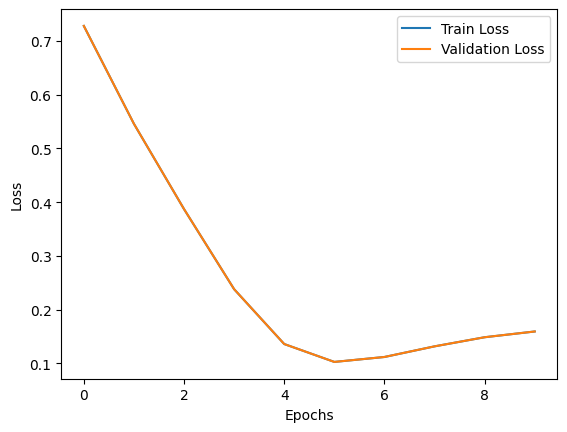

In [6]:
import matplotlib.pyplot as plt

GRU_model = GRU().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(GRU_model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

#Store the loss values
train_losses_GRU, val_losses_GRU = [], []
for epoch in range(num_epochs):
    GRU_model.train()
    X_train = X_train.float()
    Y_train = Y_train.long()
    outputs = GRU_model(X_train.to(device))
    loss = criterion(outputs, Y_train.to(device))
    train_losses_GRU.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Validation
    GRU_model.eval()
    with th.no_grad():
        X_val = X_val.float()
        Y_val = Y_val.long()
        val_outputs = GRU_model(X_val.to(device))
        val_loss = criterion(val_outputs, Y_val.to(device))
        val_losses_GRU.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Test the model
GRU_model.eval()
with th.no_grad():
    X_test = X_test.float()
    Y_test = Y_test.long()
    test_outputs = GRU_model(X_test.to(device))
    test_loss = criterion(test_outputs, Y_test.to(device))

    print(f'Test Loss: {test_loss.item():.4f}')

# Plot training and validation loss
plt.plot(train_losses_GRU, label='Train Loss')
plt.plot(val_losses_GRU, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

    

torch.Size([211238, 16, 4])
torch.Size([211238, 16, 2])
torch.Size([211238, 2, 16])
torch.Size([211238, 2, 128])
torch.Size([211238, 256])
torch.Size([211238, 128])
torch.Size([211238, 2])
torch.Size([26404, 16, 4])
torch.Size([26404, 16, 2])
torch.Size([26404, 2, 16])
torch.Size([26404, 2, 128])
torch.Size([26404, 256])
torch.Size([26404, 128])
torch.Size([26404, 2])
Epoch [1/10], Train Loss: 0.7100, Val Loss: 0.6311
torch.Size([211238, 16, 4])
torch.Size([211238, 16, 2])
torch.Size([211238, 2, 16])
torch.Size([211238, 2, 128])
torch.Size([211238, 256])
torch.Size([211238, 128])
torch.Size([211238, 2])
torch.Size([26404, 16, 4])
torch.Size([26404, 16, 2])
torch.Size([26404, 2, 16])
torch.Size([26404, 2, 128])
torch.Size([26404, 256])
torch.Size([26404, 128])
torch.Size([26404, 2])
Epoch [2/10], Train Loss: 0.6312, Val Loss: 0.5553
torch.Size([211238, 16, 4])
torch.Size([211238, 16, 2])
torch.Size([211238, 2, 16])
torch.Size([211238, 2, 128])
torch.Size([211238, 256])
torch.Size([21123

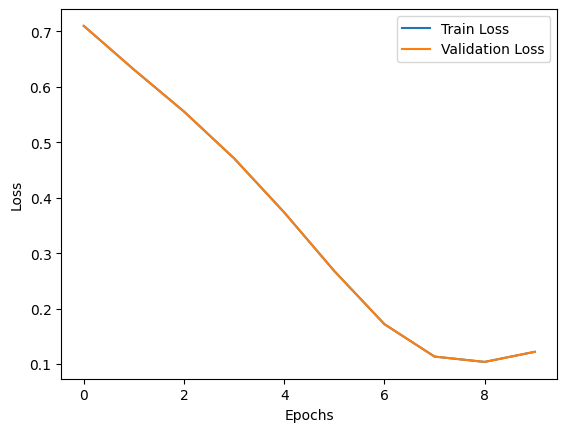

In [7]:
LSTM_model = LSTM().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(LSTM_model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

#Store the loss values
train_losses_LSTM, val_losses_LSTM = [], []
for epoch in range(num_epochs):
    LSTM_model.train()
    X_train = X_train.float()
    Y_train = Y_train.long()
    outputs = LSTM_model(X_train.to(device))
    loss = criterion(outputs, Y_train.to(device))
    train_losses_LSTM.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Validation
    LSTM_model.eval()
    with th.no_grad():
        X_val = X_val.float()
        Y_val = Y_val.long()
        val_outputs = LSTM_model(X_val.to(device))
        val_loss = criterion(val_outputs, Y_val.to(device))
        val_losses_LSTM.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
# Test the model
LSTM_model.eval()
with th.no_grad():
    X_test = X_test.float()
    Y_test = Y_test.long()
    test_outputs = LSTM_model(X_test.to(device))
    test_loss = criterion(test_outputs, Y_test.to(device))

    print(f'Test Loss: {test_loss.item():.4f}')

# Plot training and validation loss
plt.plot(train_losses_LSTM, label='Train Loss')
plt.plot(val_losses_LSTM, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

    